# Data reading

In [51]:
using DelimitedFiles, DataFrames

data = readdlm("Diabetic.txt", ',', Float32, '\n', skipstart = 24)
data = DataFrame(data)

rename!(data, [
        "quality",
        "abnormality",
        "MA1", "MA2", "MA3", "MA4", "MA5", "MA6",
        "EX1", "EX2", "EX3", "EX4", "EX5", "EX6", "EX7", "EX8",
        "macula_distance_norm",
        "optic_disc_diam",
        "AM-FM_result",
        "class"
        ])

,quality,abnormality,MA1,MA2,MA3,MA4,MA5,MA6,EX1
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,1.0,1.0,22.0,22.0,22.0,19.0,18.0,14.0,49.8958
2,1.0,1.0,24.0,24.0,22.0,18.0,16.0,13.0,57.7099
3,1.0,1.0,62.0,60.0,59.0,54.0,47.0,33.0,55.8314
4,1.0,1.0,55.0,53.0,53.0,50.0,43.0,31.0,40.4672
5,1.0,1.0,44.0,44.0,44.0,41.0,39.0,27.0,18.0263
6,1.0,1.0,44.0,43.0,41.0,41.0,37.0,29.0,28.3564
7,1.0,0.0,29.0,29.0,29.0,27.0,25.0,16.0,15.4484
8,1.0,1.0,6.0,6.0,6.0,6.0,2.0,1.0,20.6796
9,1.0,1.0,22.0,21.0,18.0,15.0,13.0,10.0,66.6919


In [47]:
using Printf
counts = combine(groupby(data, [:class]), nrow => :count)
counts_total = sum(counts.count)

@printf("Number of negative classes (0): %d [%.2f%%]\n", counts[1, "count"], counts[1, "count"]/counts_total*100)
@printf("Number of positive classes (1): %d [%.2f%%]\n", counts[2, "count"], counts[2, "count"]/counts_total*100)

Number of negative classes (0): 540 [46.92%]
Number of positive classes (1): 611 [53.08%]


In [81]:
using LinearAlgebra, Distributions

## Activation functions

In [88]:
# ----------------------- sigmoid
function sigmoid(x)
    return 1/(1+exp(-x))
end

function sigmoid_derivation(x)
    return sigmoid(x)*(1-sigmoid(x))
end

# ----------------------- ReLU
function relu(x)
    return max(0,x)
end

function relu_derivation(x)
    if x < 0
        return 0
    elseif x >= 0
        return 1
    end
end

relu_derivation (generic function with 1 method)

## Training functions

In [143]:
function feed_forward(input, weights_input, weights_output)
    hidden_input = weights_input * input
    hidden_out = map(x -> relu(x), hidden_input)

    final_input = weights_output * hidden_out
    final_out = map(x -> sigmoid(x), final_input)

    return hidden_out, final_out
end

function train(data, weights_input, weights_output, learningrate)
    for i = 1:size(data)[1]
        input = data[i,:][1:19]
        hidden_out, final_out = feed_forward(input, weights_input, weights_output)

        target_out = [Int(data[i,20])]

        error_out = target_out - final_out
        error_hidden = transpose(weights_output)*error_out

        delta_out = error_out .* map(x -> sigmoid_derivation(x), final_out)
        weights_output = weights_output + learningrate*(delta_out*transpose(hidden_out))

        delta_hidden = error_hidden .* map(x -> relu_derivation(x), hidden_out)
        weights_input = weights_input + learningrate*(delta_hidden*transpose(input))

    end
    return weights_output, weights_input
end


function predict_probability(X)
    hidden_out, final_out = feed_forward(X, nwhi, nwho)
    return final_out
end


predict_probability (generic function with 1 method)

# Hyperparameter setup

In [176]:
inputnodes = 19
outputnodes = 1
hiddennodes = 200
learningrate = 0.01

0.01

## Initialize weights randomly

In [177]:
weights_ih = rand(Uniform(-1/(hiddennodes^0.5), 1/(hiddennodes^0.5)),hiddennodes,inputnodes)
weights_ho = rand(Uniform(-1/(outputnodes^0.5), 1/(outputnodes^0.5)),outputnodes,hiddennodes)


1×200 Array{Float64,2}:
 -0.742405  -0.569484  -0.932198  -0.112672  …  0.799704  0.914729  0.597449

In [178]:
function validate(nwhi, nwho)
    validation_acc = 0.0
    true_output = 0
    samples_no = size(validation_data, 1)
    
    classified_correctly = 0
    for i = 1:samples_no
        true_output = validation_data[i, end]
        
        if round(predict_probability(validation_data[i, 1:19])[1]) == true_output
            classified_correctly += 1
        end
        
    end
    
    return classified_correctly/samples_no
end


validate (generic function with 1 method)

In [250]:
data = readdlm("Diabetic.txt", ',', Float32, '\n', skipstart = 24)
data = normalization(copy(data))

nwhi = weights_ih
nwho = weights_ho

train_data = data[1:865,:]
validation_data = data[866:981,:]
test_data = data[982:end,:]


accuracies = Float64[]
epochs_no = 300

for epochs = 1:epochs_no
    global nwho, nwhi = train(data[1:865,:], nwhi, nwho, learningrate)
    append!(accuracies, validate(nwhi, nwho))    
end

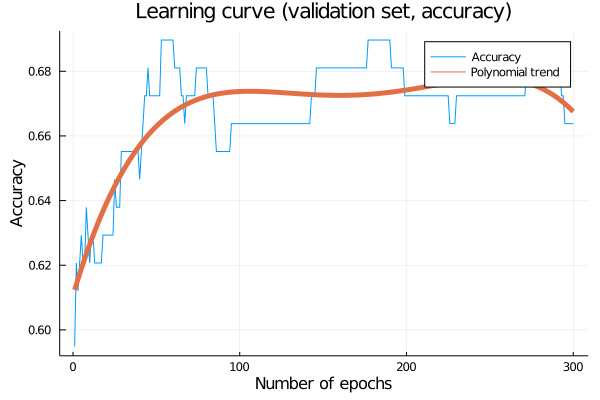

In [294]:
using Plots

xs = range(1, epochs_no, length=epochs_no)
p = Polynomials.fit(xs, accuracies, 4)

plot(xs, accuracies, label="Accuracy")
plot!(p, Polynomials.extrema(xs)..., label="Polynomial trend", lw=5)
xlabel!("Number of epochs")
ylabel!("Accuracy")
title!("Learning curve (validation set, accuracy)")

In [302]:
function test(nwhi, nwho)
    test_acc = 0.0
    true_output = 0
    samples_no = size(test_data, 1)
    
    classified_correctly = 0
    for i = 1:samples_no
        true_output = test_data[i, end]
        
        if round(predict_probability(test_data[i, 1:19])[1]) == true_output
            classified_correctly += 1
        end
        
    end
    
    return classified_correctly/samples_no
end

@printf("Accuracy on test set: %.2f%%", test(nwhi, nwho)*100)
using EvalMetrics
binary_eval_report(labels, scores)

Accuracy on test set: 74.12%

Dict{String,Real} with 8 entries:
  "precision@fpr0.05"          => 0.909091
  "recall@fpr0.05"             => 0.481928
  "accuracy@fpr0.05"           => 0.723529
  "au_prcurve"                 => 0.851897
  "samples"                    => 170
  "true negative rate@fpr0.05" => 0.954023
  "au_roccurve"                => 0.831879
  "prevalence"                 => 0.488235

In [329]:
thres = 0.5
predicts  = scores .>= thres;
cm = ConfusionMatrix(labels, predicts)

@printf("Actual positives: %d\nActual negatives: %d\n\nTrue Posivites: %d\nFalse Positives: %d\nFalse Negatives: %d\nTrue Negatives: %d",
    cm.p, cm.n, cm.tp, cm.fp, cm.fn, cm.tn)

Actual positives: 83
Actual negatives: 87

True Posivites: 53
False Positives: 14
False Negatives: 30
True Negatives: 73

In [ ]:
scores = Float64[]
labels = Float64[]

for i = 1:size(test_data, 1)
    append!(scores, predict_probability(test_data[i, 1:19])[1])
    append!(labels, test_data[i, end])

end


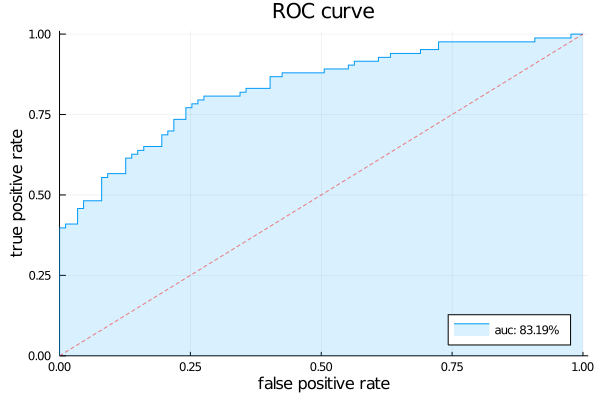

In [310]:
rocplot(labels, scores)

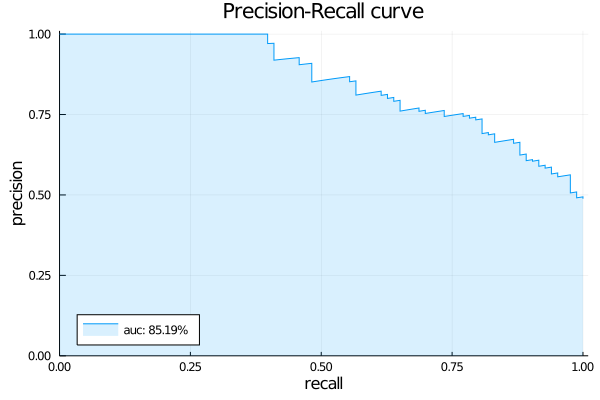

In [309]:
prplot(labels, scores)